# Create GeoDataFrame from Bufr File

In [1]:
from shapely.geometry import Point
from gpdbufr import read_geo_bufr, distance

TEST_DATA_GEOPANDAS = "Z__C_EDZW_20210516120400_bda01,synop_bufr_GER_999999_999999__MW_466.bin"

def getWindData(file,center,radius=100):
    radius = radius * 1000  # radius in km
    columns = [
                "WMO_station_id",
                "stationOrSiteName",
                "latitude",
                "longitude",
                "geometry",
                "CRS",
                "typicalDate",
                "typicalTime",
                "timeSignificance",
                "timePeriod",
                "windDirection",
                "windSpeed",
              ]
    filters = dict(
                windDirection=float,
                windSpeed=float,
                geometry=lambda x: distance(center, Point(x)) < radius,
              )
    df_all = read_geo_bufr(file, columns, filters)
    return df_all


centerLatLon = [11.010754, 47.800864]
centerLonLat = [centerLatLon[1],centerLatLon[0]]
center = Point(centerLatLon)  # Hohenpeißenberg
rs = getWindData(TEST_DATA_GEOPANDAS,center)
rs

,typicalDate,typicalTime,stationOrSiteName,latitude,longitude,timePeriod,timeSignificance,windSpeed,windDirection,WMO_station_id,geometry,CRS
0,20210516,115000,Augsburg,48.42529,10.94168,-10,2,2.6,270,10852,POINT Z (10.94168 48.42529 461.50000),EPSG:4326
1,20210516,115000,Kempten,47.72326,10.33480,-10,2,3.7,210,10946,POINT Z (10.33480 47.72326 705.20000),EPSG:4326
2,20210516,115000,Muenchen-Flughafen,48.34774,11.81339,-10,2,6.2,210,10870,POINT Z (11.81339 48.34774 445.50000),EPSG:4326
3,20210516,115000,Oberstdorf,47.39843,10.27588,-10,2,2.5,310,10948,POINT Z (10.27588 47.39843 805.80000),EPSG:4326
4,20210516,115000,Zugspitze,47.42104,10.98476,-10,2,6.2,220,10961,POINT Z (10.98476 47.42104 2964.50000),EPSG:4326
5,20210516,115000,Hohenpeissenberg,47.80087,11.01082,-10,2,5.8,220,10962,POINT Z (11.01082 47.80087 977.20000),EPSG:4326
6,20210516,115000,Weihenstephan-Duerna,48.40240,11.69455,-10,2,6.0,260,10863,POINT Z (11.69455 48.40240 477.10000),EPSG:4326
7,20210516,115000,Muenchen-Stadt,48.16320,11.54289,-10,2,5.1,240,10865,POINT Z (11.54289 48.16320 515.40000),EPSG:4326
8,20210516,115000,Leutkirch-Herlazhofe,47.79551,10.03243,-10,2,4.9,220,10945,POINT Z (10.03243 47.79551 671.70000),EPSG:4326
9,20210516,115000,Garmisch-Partenkirch,47.48299,11.06213,-10,2,2.4,30,10963,POINT Z (11.06213 47.48299 719.30000),EPSG:4326


# Using GeoDataFrame with matplotlib and geopandas.world

- [matplotlib](https://matplotlib.org)
- [geopandas](https://geopandas.org)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

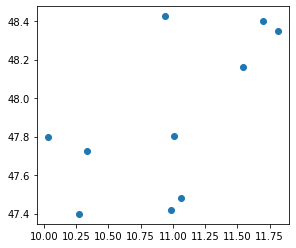

In [2]:
%matplotlib inline
import geopandas
import matplotlib.pyplot as plt
rs.plot()
rs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

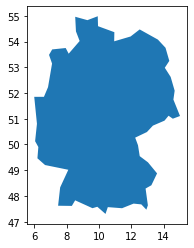

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = world[world['continent'] == "Europe"]
germany = countries[countries['name'] == "Germany"]
germany.plot()
countries = countries[['geometry', 'name']]
countries.crs

In [4]:
germany = germany.to_crs('epsg:3395')
locations = rs.to_crs('epsg:3395')

<AxesSubplot:>

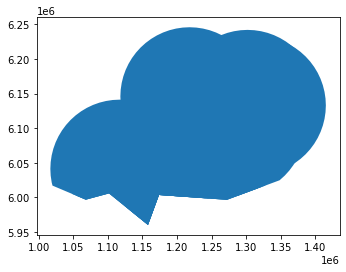

In [5]:
locations['geometry']= locations.buffer(100000)
rs_ovl = geopandas.overlay(germany,locations)
rs_ovl.plot()

# Using GeoDataFrame with Folium and Leaflet

- [Folium](https://github.com/python-visualization/folium)
- [Leaflet](https://github.com/Leaflet/Leaflet)

## Move to each location and click on the marker

In [6]:
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip

m=folium.Map(location=[center.y, center.x], zoom_start=8)

popup = GeoJsonPopup(
    fields=["stationOrSiteName", "typicalDate", "typicalTime", "windDirection", "windSpeed"],
    aliases=["Location", "Date", "Time", "Direction", "Speed"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)


folium.GeoJson(rs[['geometry','stationOrSiteName',"typicalDate", "typicalTime","windDirection","windSpeed"]],
               name="Windberechnungen",
               highlight_function=lambda x: {'weight':3, 'color':'black'},
               smooth_factor=2.0,
               tooltip=folium.features.GeoJsonTooltip(fields=['stationOrSiteName', "typicalTime",],
                                              aliases=["Location", "Time", ], 
                                              labels=True, 
                                              sticky=True,
                                             ),
               popup=popup
               ).add_to(m)

folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

m

# Using GeoDataFrame with windrose

- [windrose](https://github.com/scls19fr/windrose)

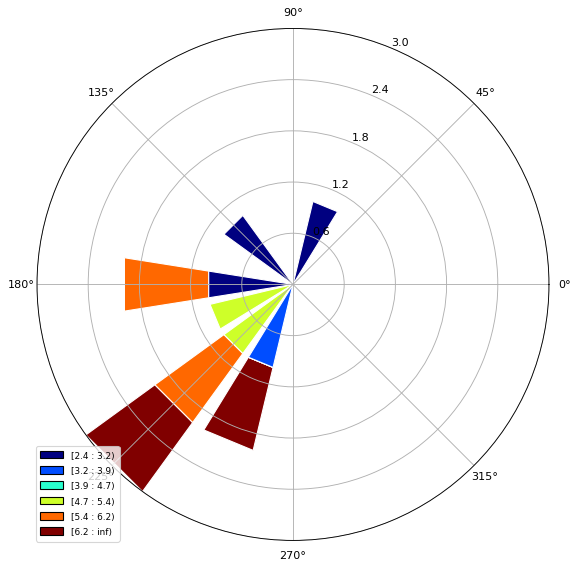

In [7]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(rs.windDirection, rs.windSpeed, edgecolor='white')
ax.set_legend()